In [5]:
# Cella 1: Reset, Clone e Configurazione Ambiente

import os
import sys

# 1. --- RESET AMBIENTE ---
# Torna alla directory di base e rimuovi il repository
print("Esecuzione Reset Ambiente...")
try:
    os.chdir('/content/')
    !rm -rf Hawk-AI-CV-Project
except:
    pass

# 2. --- CLONAZIONE ---
!git clone https://github.com/leonardoCosta02/Hawk-AI-CV-Project.git

# 3. --- CAMBIO DIRECTORY (CD) E PATH ---
repo_name = "Hawk-AI-CV-Project"
%cd $repo_name

# Aggiungi la radice del repo al PATH di Python
sys.path.insert(0, os.getcwd())

# 4. --- INSTALLAZIONE LIBRERIE ---
print("Installazione librerie necessarie...")
!pip install numpy opencv-python matplotlib

print("\nSetup completato. Ora la tua root è:")
print(os.getcwd())

Esecuzione Reset Ambiente...
Cloning into 'Hawk-AI-CV-Project'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 189 (delta 0), reused 0 (delta 0), pack-reused 185 (from 1)
Receiving objects: 100% (189/189), 4.11 MiB | 7.17 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/Hawk-AI-CV-Project
Installazione librerie necessarie...

Setup completato. Ora la tua root è:
/content/Hawk-AI-CV-Project


In [6]:
# Cella 1.5: Pulizia Cache Moduli

import importlib
import sys

# Rimuove i moduli specifici dalla cache di Python, forzando un reload completo in Cella 2
if 'src.config' in sys.modules:
    del sys.modules['src.config']
if 'src.court_features' in sys.modules:
    del sys.modules['src.court_features']

print("Cache dei moduli 'config' e 'court_features' eliminata. La Cella 2 caricherà i file freschi.")

Cache dei moduli 'config' e 'court_features' eliminata. La Cella 2 caricherà i file freschi.


In [7]:
# Cella 2: Caricamento Dati, Pre-processing e Fix Cache

# --- IMPORTAZIONE DEI MODULI NECESSARI ---
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib # Necessario per il ricaricamento dei moduli

# Importa i moduli la prima volta (dal tuo percorso 'src')
from src import config
from src import court_features # Importa il modulo completo

# --- 1. PULIZIA FORZATA E RICARICAMENTO (FIX DEL TYPERROR) ---
print("Ricaricamento forzato dei moduli per pulizia cache...")

# Ora puoi importare la funzione 'trova_linee' dalla versione aggiornata
from src.court_features import trova_linee

print("Moduli aggiornati. La funzione trova_linee ha ora la firma corretta (2 argomenti).")

# --- 2. LOGICA DI CARICAMENTO DATI ---
# (Assumiamo che CAMPI_PATH sia stata aggiunta nel config.py)

immagini_caricate = {}   # Dizionario vuoto che conterrà i frame caricati, indicizzati per tipo di superficie

print("\nCaricamento frame per le 3 superfici...")  # Messaggio informativo su stdout

# Usa config.CAMPI_PATH per il loop di caricamento
for superficie, path in config.CAMPI_PATH.items():
    # .items() restituisce coppie (chiave, valore) dal dizionario CAMPI_PATH:
    # - 'superficie' sarà la chiave (es. 'CEMENTO', 'ERBA', 'TERRA_BATTUTA')
    # - 'path' sarà il valore (es. 'data/campo_cemento.jpg')

    # Continua con il caricamento
    image_bgr = cv.imread(path)  # cv.imread legge il file immagine dal disco e restituisce un np.ndarray BGR o None se fallisce

    if image_bgr is None:
        # Se cv.imread non trova/legge il file, restituisce None -> qui gestiamo l'errore
        print(f"ERRORE CRITICO: Impossibile caricare l'immagine da {path}.")
        print("PASSAGGIO MANCANTE: Controlla che i file JPG siano fisicamente in /content/Hawk-AI-CV-Project/data/.")
    else:
        # Se l'immagine è stata letta correttamente:
        # - manteniamo la versione BGR per il processing con OpenCV
        # - creiamo una copia convertita in RGB per eventuale visualizzazione (matplotlib, PIL, ecc.)
        immagini_caricate[superficie] = {
            'bgr': image_bgr,
            'rgb': cv.cvtColor(image_bgr, cv.COLOR_BGR2RGB)
        }
        #'CEMENTO': {'bgr': <np.ndarray>, 'rgb': <np.ndarray>}

# Dopo il loop controlliamo se abbiamo caricato almeno una immagine
if not immagini_caricate:
    print("Nessun frame caricato. Termino l'esecuzione.")
else:
    print(f"Caricamento completato per {len(immagini_caricate)} tipi di campo.")


Ricaricamento forzato dei moduli per pulizia cache...
Moduli aggiornati. La funzione trova_linee ha ora la firma corretta (2 argomenti).

Caricamento frame per le 3 superfici...
Caricamento completato per 3 tipi di campo.



== TEST SUPERFICIE: CEMENTO ==
   Parametri CANNY usati: LOW=25, HIGH=80
   Soglia HOUGH usata: 65

✅ OUTPUT M3 (PRIME 5 LINEE per CEMENTO):
[[  0   7 274   7]
 [ 25 127 248 127]
 [  0   4 274   4]
 [ 25  52 246  52]
 [ 25 140 248 140]]
Forma dell'array: (20, 4)


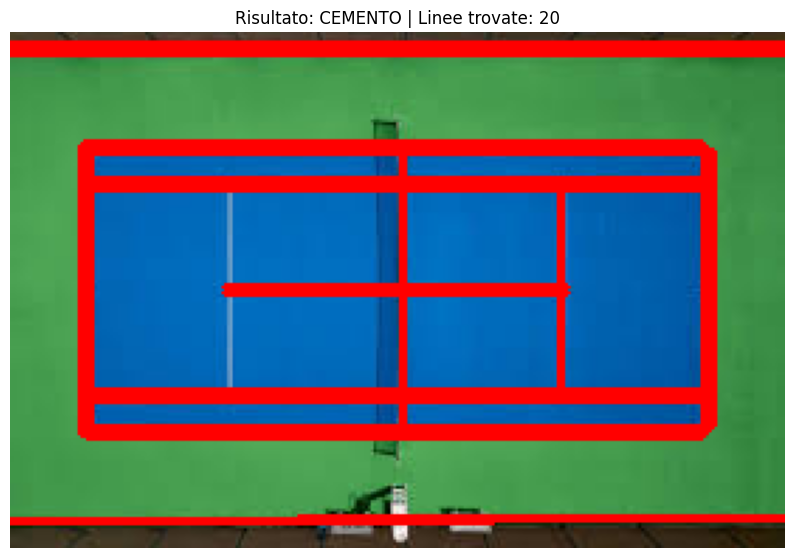


== TEST SUPERFICIE: ERBA ==
   Parametri CANNY usati: LOW=30, HIGH=120
   Soglia HOUGH usata: 65


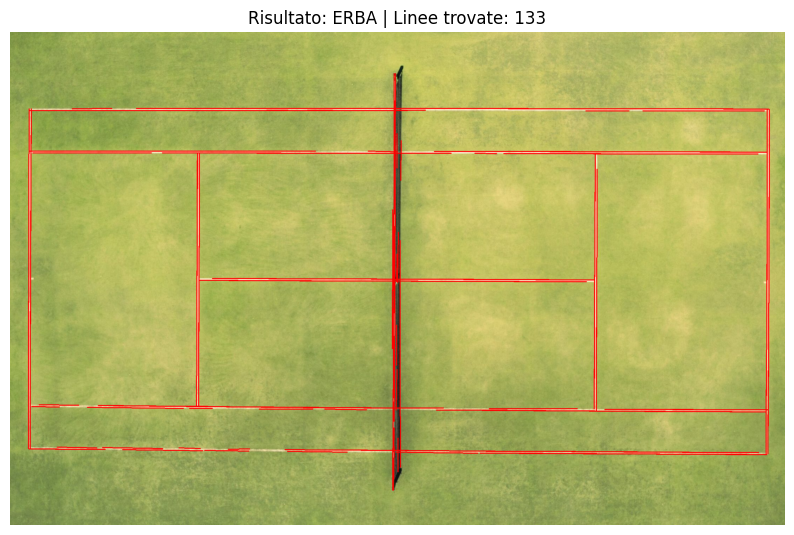


== TEST SUPERFICIE: TERRA_BATTUTA ==
   Parametri CANNY usati: LOW=40, HIGH=180
   Soglia HOUGH usata: 30


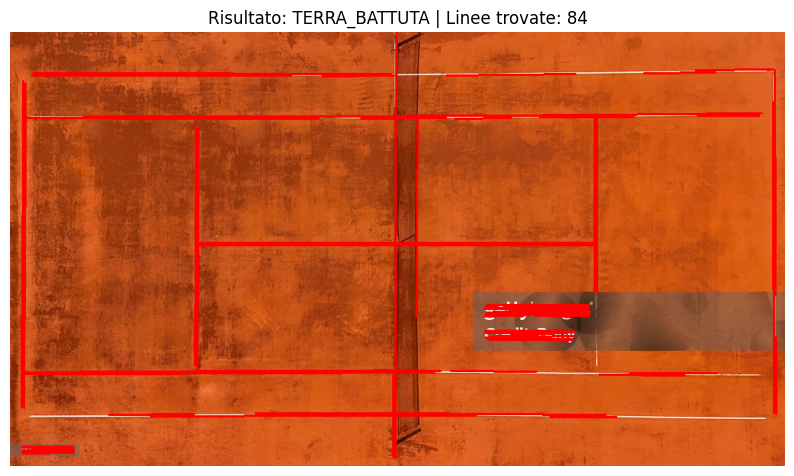


======================= RIEPILOGO COMPLETO =======================
OBIETTIVO DI TUNING: Ottenere circa 10-15 linee trovate e ben disegnate per campo.

SUPERFICIE: CEMENTO
  -> Linee Trovate: 20
  -> Canny/Hough Usati: 80/65

SUPERFICIE: ERBA
  -> Linee Trovate: 133
  -> Canny/Hough Usati: 120/65

SUPERFICIE: TERRA_BATTUTA
  -> Linee Trovate: 84
  -> Canny/Hough Usati: 180/30


In [8]:
# Cella 3: Esecuzione del Loop di Tuning e Visualizzazione dei Risultati

# Nota: Assicurati che le Celle 1 e 2 siano state eseguite senza errori per avere 'immagini_caricate' e 'config' disponibili.

risultati_finali = {}   # Dizionario che accumulerà i risultati (uno per ogni superficie)
# STAMPA DEL PARAMETRO COMUNE: Accedi direttamente a config.HOUGH_COMMON_PARAMS
# (Assumendo che 'config' sia stato importato correttamente in Cella 2)

# --- 1. LOOP DI TUNING PER OGNI SUPERFICIE ---
for superficie, dati_immagine in immagini_caricate.items():
    # itera sul dizionario immagini_caricate; ad ogni iterazione:
    # - 'superficie' è la chiave (es. 'CEMENTO', 'ERBA', ...)
    # - 'dati_immagine' è il valore associato (dizionario con 'bgr' e 'rgb')

    # Recupera i parametri dal file di configurazione
    # (Questa riga funziona perché la Cella 2 ha ricaricato correttamente il modulo config)
    params = config.ALL_SURFACE_PARAMS[superficie]
    # ora 'params' è un dizionario con i parametri CANNY/HOUGH per la superficie corrente

    # Stampa informativa di inizio test per la superficie corrente
    print(f"\n========================================================")
    print(f"== TEST SUPERFICIE: {superficie} ==")
    print(f"   Parametri CANNY usati: LOW={params['CANNY_LOW']}, HIGH={params['CANNY_HIGH']}")
    print(f"   Soglia HOUGH usata: {params['HOUGH_THRESHOLD']}")
    print(f"========================================================")

    # --- ESECUZIONE DELLA FUNZIONE (Pulita) ---
    # chiama la funzione che fa preprocessing + Canny + Hough e restituisce i segmenti grezzi
    raw_line_segments = trova_linee(dati_immagine['bgr'], superficie)
    # raw_line_segments dovrebbe essere un np.ndarray con shape (N,4) oppure array vuoto

    # --- AGGIUNGI QUI LA STAMPA PER IL MEMBRO 3 ---
    if superficie == 'CEMENTO':
        # Stampa diagnostica solo per la superficie 'CEMENTO' (qui mostriamo le prime 5 linee)
        print(f"\n✅ OUTPUT M3 (PRIME 5 LINEE per {superficie}):")
        # raw_line_segments[:5] mostra fino a 5 segmenti (se ce ne sono)
        print(raw_line_segments[:5])
        # ATTENZIONE: se raw_line_segments è un array vuoto con shape (0,), .shape è comunque accessibile
        print(f"Forma dell'array: {raw_line_segments.shape}")
    # -----------------------------------------------

    # --- 2. VISUALIZZAZIONE DEI RISULTATI ---
    line_frame = np.copy(dati_immagine['rgb'])
    # copio la versione RGB per fare il disegno (così non modifico l'immagine originale)
    linee_trovate = len(raw_line_segments)
    # len su un ndarray vuoto = 0; su array (N,4) restituisce N

    if linee_trovate > 0:
        # Se ci sono segmenti, disegniamo tutte le linee in ROSSO (RGB=(255,0,0))
        # Nota: cv.line si aspetta coordinate intere; assicurati che gli array siano int
        for x1, y1, x2, y2 in raw_line_segments:
            cv.line(line_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Visualizza il risultato con matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(line_frame)  # mostra l'immagine RGB con le linee sovrapposte
    plt.title(f"Risultato: {superficie} | Linee trovate: {linee_trovate}")
    plt.axis('off')
    plt.show()

    # 3. Registra i risultati per il riepilogo (salviamo sia i parametri che l'output)
    risultati_finali[superficie] = {
        'Canny Low': params['CANNY_LOW'],
        'Canny High': params['CANNY_HIGH'],
        'Hough Threshold': params['HOUGH_THRESHOLD'],
        'Totale Linee Trovate': linee_trovate,
        'Raw Segments': raw_line_segments # Teniamo l'array completo registrato
    }

# --- RIEPILOGO FINALE ---
print("\n======================= RIEPILOGO COMPLETO =======================")
print("OBIETTIVO DI TUNING: Ottenere circa 10-15 linee trovate e ben disegnate per campo.")

for superficie, params in risultati_finali.items():
    # per ogni superficie stampiamo il conteggio di linee e i parametri usati
    print(f"\nSUPERFICIE: {superficie}")
    print(f"  -> Linee Trovate: {params['Totale Linee Trovate']}")
    print(f"  -> Canny/Hough Usati: {params['Canny High']}/{params['Hough Threshold']}")